In [ ]:
import torch
import torch.optim as optim
import numpy as np
import scanpy as sc
import scvelo as scv
from model import NETWORK  # Ensure that model.py is saved in the same directory
from dataloaders import setup_dataloaders  # Ensure that dataloaders.py is saved in the same directory
from utils import manifold_and_neighbors
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import shortest_path

from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import shortest_path
from scipy.sparse import csr_matrix
import numpy as np
import scvelo as scv
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra


# Setup configuration
latent_dim = 64  # Latent dimension size, can be adjusted
hidden_dim = 512  # Hidden dimension size for the encoder and decoder
batch_size = 12  # Batch size for training
epochs = 10  # Number of epochs for training
learning_rate = 1e-4  # Learning rate for the optimizer
lambda1 = 1e-1  # Weight for heuristic loss
lambda2 = 1 # Weight for discrepancy loss
K = 11  # Number of neighbors for heuristic loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available

n_components = 100
n_knn_search = 10
dataset_name = "gastrulation_erythroid"
cell_type_key = "celltype"
model_name = "imVelo"


# Load data
adata = scv.datasets.gastrulation_erythroid()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
adata = adata[adata.obs["stage"]=="E8.25"].copy()
scv.pp.moments(adata, n_neighbors=200)

# Use spliced matrix for Isomap embedding
Mu = adata.layers["unspliced"].toarray()
Ms = adata.layers["spliced"].toarray()
Mu_Ms = np.concatenate([Mu,Ms],axis=1)
n_neighbors = 40  # Number of neighbors to consider
# Step 1: Create a nearest-neighbor graph (Euclidean distances for the graph construction)
knn_graph = kneighbors_graph(Mu_Ms, n_neighbors=n_neighbors, mode='distance', include_self=False)

# Step 2: Compute the geodesic distances using Dijkstra's algorithm
# This returns the shortest paths between all pairs of points
geodesic_distances = dijkstra(csgraph=knn_graph, directed=False, return_predecessors=False)

# Step 3: Build the neighbor matrix
# For each cell, find its nearest neighbors based on geodesic distances
nearest_neighbors = []
for i in range(geodesic_distances.shape[0]):
    sorted_indices = np.argsort(geodesic_distances[i])
    nearest_neighbors.append(sorted_indices[:n_neighbors + 1])  # Include the cell itself

nearest_neighbors_matrix = np.array(nearest_neighbors)


adata.uns["indices"] = nearest_neighbors_matrix

# Compute moments using the custom neighbor graph
#scv.pp.moments(adata, n_neighbors=200, use_rep="isomap")

input_dim = adata.shape[1] * 2  # Assuming 2000 unspliced and 2000 spliced genes as input

# Initialize model, optimizer, and loss function
model = NETWORK(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up data loaders
train_loader, test_loader, full_data_loader = setup_dataloaders(adata, batch_size=batch_size, train_size=1, split_data=False)

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for batch_idx, (inputs, batch_indices) in enumerate(train_loader):
        inputs = inputs.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        out_dic = model(inputs)
        
        # Compute loss
        losses_dic = model.heuristic_loss(
            adata=adata, 
            x=inputs, 
            batch_indices=batch_indices,
            lambda1=lambda1, 
            lambda2=lambda2, 
            out_dic=out_dic, 
            device=device,
            K=K
        )
        
        # Backward pass and optimization
        loss = losses_dic["total_loss"]
        loss.backward()
        optimizer.step()
        
        # Accumulate loss for monitoring
        running_loss += loss.item()
        
        if batch_idx % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}], Loss: {loss.item()}')
    
    print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss / len(train_loader)}')

    # Save the model periodically
    """if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')"""

# After training, save final model
torch.save(model.state_dict(), 'final_model.pth')
"""
# Test the model on the test set (if available)
if test_loader is not None:
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0.0
    with torch.no_grad():
        for inputs, batch_indices in test_loader:
            inputs = inputs.to(device)
            out_dic = model(inputs)
            
            # Compute test loss
            losses_dic = model.heuristic_loss(
                adata=adata, 
                x=inputs, 
                batch_indices=batch_indices,
                lambda1=lambda1, 
                lambda2=lambda2, 
                out_dic=out_dic, 
                device=device,
                K=K
            )
            total_test_loss += losses_dic["total_loss"].item()

    print(f'Test Loss: {total_test_loss / len(test_loader)}')"""

# Initialize empty layers in adata for storing results
adata.layers["velocity_u"] = np.zeros_like(adata.layers["Mu"])  # Initialize for velocity_u
adata.layers["velocity"] = np.zeros_like(adata.layers["Ms"])  # Initialize for velocity (spliced)
adata.layers["pp"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["nn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["pn"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.layers["np"] = np.zeros_like(adata.layers["Mu"])  # Same shape as Mu
adata.obsm["pred"] = np.zeros((adata.shape[0], adata.shape[1] * 2))  # Assuming 2*genes for prediction

# Fetch output dictionary for the entire dataset after training and store results in adata layers
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for inputs, batch_indices in full_data_loader:
        inputs = inputs.to(device)
        out_dic = model(inputs)

        # Store the results in adata layers according to batch_indices
        adata.layers["velocity_u"][batch_indices] = out_dic["v_u"].cpu().numpy()
        adata.layers["velocity"][batch_indices] = out_dic["v_s"].cpu().numpy()
        adata.layers["pp"][batch_indices] = out_dic["pp"].cpu().numpy()
        adata.layers["nn"][batch_indices] = out_dic["nn"].cpu().numpy()
        adata.layers["pn"][batch_indices] = out_dic["pn"].cpu().numpy()
        adata.layers["np"][batch_indices] = out_dic["np"].cpu().numpy()

        # Store predictions in adata.obsm
        adata.obsm["pred"][batch_indices] = out_dic["pred"].cpu().numpy()

print('Results stored in adata.layers and adata.obsm')


Filtered out 47456 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.
Logarithmized X.
computing neighbors


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Epoch [1/10], Batch [0], Loss: 0.11347924172878265
Epoch [1/10], Batch [10], Loss: 0.01706327684223652
Epoch [1/10], Batch [20], Loss: 0.023585524410009384
Epoch [1/10], Batch [30], Loss: 0.006455805152654648
Epoch [1/10], Batch [40], Loss: 0.02860158495604992
Epoch [1/10], Batch [50], Loss: 0.021944675594568253
Epoch [1/10], Batch [60], Loss: 0.028220180422067642
Epoch [1/10], Batch [70], Loss: 0.021494071930646896
Epoch [1/10], Batch [80], Loss: 0.005342094227671623
Epoch [1/10], Batch [90], Loss: 0.01002503465861082
Epoch [1/10], Batch [100], Loss: 0.022282898426055908
Epoch [1/10], Batch [110], Loss: 0.009379344992339611
Epoch [1/10], Batch [120], Loss: 0.026010707020759583
Epoch [1/10], Batch [130], Loss: 0.044775258749723434
Epo

computing velocity graph (using 1/24 cores)


    finished (0:00:24) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs

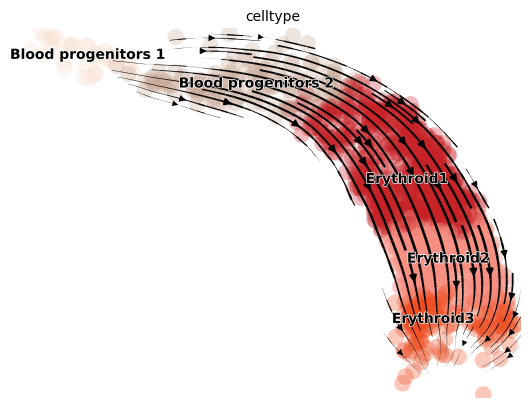

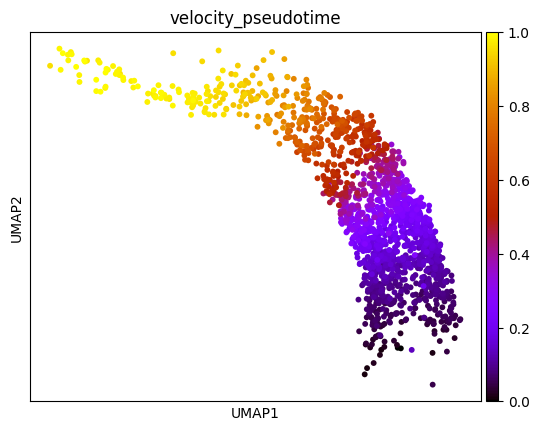

In [13]:
adata.layers["velocity"] *= -1
adata.layers["velocity_u"] *= -1

scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding_stream(adata, color=cell_type_key)
scv.tl.velocity_pseudotime(adata)
sc.pl.umap(adata, color="velocity_pseudotime", cmap="gnuplot")

In [14]:
import matplotlib.pyplot as plt

def plot_phase_plane(adata, gene_name, dataset, K, u_scale=.01, s_scale=0.01, alpha=0.5, head_width=0.02, head_length=0.03, length_includes_head=False, log=False,
                        norm_velocity=True, filter_cells=False, smooth_expr=True, show_plot=True, save_plot=True, save_path=".",
                        cell_type_key="clusters"):

    if smooth_expr:
        unspliced_expression = adata.layers["Mu"][:, adata.var_names.get_loc(gene_name)].flatten() 
        spliced_expression = adata.layers["Ms"][:, adata.var_names.get_loc(gene_name)].flatten() 
    else:
        unspliced_expression = adata.layers["unspliced"][:, adata.var_names.get_loc(gene_name)].flatten()
        spliced_expression = adata.layers["spliced"][:, adata.var_names.get_loc(gene_name)].flatten()

    # Normalize the expression data
    unspliced_expression_min, unspliced_expression_max = np.min(unspliced_expression), np.max(unspliced_expression)
    spliced_expression_min, spliced_expression_max = np.min(spliced_expression), np.max(spliced_expression)

    # Min-Max normalization
    unspliced_expression = (unspliced_expression - unspliced_expression_min) / (unspliced_expression_max - unspliced_expression_min)
    spliced_expression = (spliced_expression - spliced_expression_min) / (spliced_expression_max - spliced_expression_min)

    # Extract the velocity data
    unspliced_velocity = adata.layers['velocity_u'][:, adata.var_names.get_loc(gene_name)].flatten()
    spliced_velocity = adata.layers['velocity'][:, adata.var_names.get_loc(gene_name)].flatten()

    def custom_scale(data):
        max_abs_value = np.max(np.abs(data))  # Find the maximum absolute value
        scaled_data = data / max_abs_value  # Scale by the maximum absolute value
        return scaled_data

    if norm_velocity:
        unspliced_velocity = custom_scale(unspliced_velocity)
        spliced_velocity = custom_scale(spliced_velocity)


    # Apply any desired transformations (e.g., log) here
    if log:
        # Apply log transformation safely, ensuring no log(0)
        unspliced_velocity = np.log1p(unspliced_velocity)
        spliced_velocity = np.log1p(spliced_velocity)

    # Generate boolean masks for conditions and apply them
    if filter_cells:
        valid_idx = (unspliced_expression > 0) & (spliced_expression > 0)
    else:
        valid_idx = (unspliced_expression >= 0) & (spliced_expression >= 0)

    # Filter data based on valid_idx
    unspliced_expression_filtered = unspliced_expression[valid_idx]
    spliced_expression_filtered = spliced_expression[valid_idx]
    unspliced_velocity_filtered = unspliced_velocity[valid_idx]
    spliced_velocity_filtered = spliced_velocity[valid_idx]

    # Also filter cell type information to match the filtered expressions
    # First, get unique cell types and their corresponding colors
    unique_cell_types = adata.obs[cell_type_key].cat.categories
    celltype_colors = adata.uns[f"{cell_type_key}_colors"]
    
    # Create a mapping of cell type to its color
    celltype_to_color = dict(zip(unique_cell_types, celltype_colors))

    # Filter cell types from the data to get a list of colors for the filtered data points
    cell_types_filtered = adata.obs[cell_type_key][valid_idx]
    colors = cell_types_filtered.map(celltype_to_color).to_numpy()
    plt.figure(figsize=(9, 6.5), dpi=100)
  # Lower dpi here if the file is still too large    scatter = plt.scatter(unspliced_expression_filtered, spliced_expression_filtered, c=colors, alpha=0.6)

    """# Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            unspliced_expression_filtered[i], spliced_expression_filtered[i], 
            unspliced_velocity_filtered[i] * u_scale, spliced_velocity_filtered[i] * s_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )"""

    # Plot velocity vectors
    for i in range(len(unspliced_expression_filtered)):
        cell_type_index = np.where(unique_cell_types == cell_types_filtered[i])[0][0]
        arrow_color = celltype_to_color[cell_types_filtered[i]]  # Use the color corresponding to the cell type
        plt.arrow(
            spliced_expression_filtered[i], unspliced_expression_filtered[i], 
            spliced_velocity_filtered[i] * s_scale, unspliced_velocity_filtered[i] * u_scale, 
            color=arrow_color, alpha=alpha, head_width=head_width, head_length=head_length, length_includes_head=length_includes_head
        )

    plt.ylabel(f'Normalized Unspliced Expression of {gene_name}')
    plt.xlabel(f'Normalized Spliced Expression of {gene_name}')
    plt.title(f'Expression and Velocity of {gene_name} by Cell Type')

    # Create a legend
    patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=celltype_to_color[celltype], markersize=10, label=celltype) 
            for celltype in unique_cell_types]
    plt.legend(handles=patches, title="Cell Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    

    if save_plot:
        plt.savefig(save_path, format='png', bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    # Check if show_plot is True, then display the plot
    if show_plot:
        plt.show()
    else:
        plt.close()

    plt.show()


In [15]:
list(adata.var_names)

['Vcpip1',
 'Snhg6',
 'Arfgef1',
 'Tram1',
 'Ogfrl1',
 'Fam135a',
 'Phf3',
 'Bag2',
 'Zfp451',
 'Uggt1',
 'Actr1b',
 'Tmem131',
 'Mitd1',
 'Rev1',
 'Aff3',
 'Uxs1',
 'Tex30',
 'Kdelc1',
 'Slc39a10',
 'Pms1',
 'Hspd1',
 'Clk1',
 'Orc2',
 'Fam126b',
 'Tmem237',
 'Wdr12',
 'Ino80d',
 'Klf7',
 'Idh1',
 'Ikzf2',
 'Bard1',
 'Fn1',
 'Usp37',
 'Serpine2',
 'Cul3',
 'Trip12',
 'Ncl',
 'Usp40',
 'Hjurp',
 'Pask',
 'Hdlbp',
 'Dtymk',
 'D1Ertd622e',
 'Ppip5k2',
 'Pam',
 'Epb41l5',
 'Dbi',
 'Actr3',
 'Tmem163',
 'Cd55',
 'Mapkapk2',
 'Tmcc2',
 'Btg2',
 'Rnpep',
 'Ipo9',
 'Nek7',
 'Cdc73',
 'Pla2g4a',
 'BC003331',
 'Gm10138',
 '1700025G04Rik',
 'Tsen15',
 'Rgl1',
 'Smg7',
 'Lamc1',
 'Dhx9',
 'Npl',
 'Cep350',
 'Soat1',
 'Fam20b',
 'Ralgps2',
 'Rasal2',
 'Cacybp',
 'Suco',
 'Prrc2c',
 'Mpzl1',
 'Uck2',
 'Mgst3',
 'Pbx1',
 'Uap1',
 'Fcer1g',
 'Ppox',
 'Pea15a',
 'Cep170',
 'Adss',
 'H3f3a',
 'Nvl',
 'Lbr',
 'Enah',
 'Degs1',
 'Capn2',
 'Mia3',
 'Cenpf',
 'Smyd2',
 'Flvcr1',
 'Nenf',
 'Ppp2r5a',
 'Dtl'

In [16]:
adata.var_names

Index(['Vcpip1', 'Snhg6', 'Arfgef1', 'Tram1', 'Ogfrl1', 'Fam135a', 'Phf3',
       'Bag2', 'Zfp451', 'Uggt1',
       ...
       'Acot9', 'Sh3kbp1', 'Rbbp7', 'Gemin8', 'Gpm6b', 'Arhgap6', 'Uty',
       'Ddx3y', 'Eif2s3y', 'Gm47283'],
      dtype='object', name='index', length=3000)

In [17]:
adata.var_names

Index(['Vcpip1', 'Snhg6', 'Arfgef1', 'Tram1', 'Ogfrl1', 'Fam135a', 'Phf3',
       'Bag2', 'Zfp451', 'Uggt1',
       ...
       'Acot9', 'Sh3kbp1', 'Rbbp7', 'Gemin8', 'Gpm6b', 'Arhgap6', 'Uty',
       'Ddx3y', 'Eif2s3y', 'Gm47283'],
      dtype='object', name='index', length=3000)

In [18]:
#Rpl18a Hba-x Alas2

In [19]:
list(adata.var_names)

['Vcpip1',
 'Snhg6',
 'Arfgef1',
 'Tram1',
 'Ogfrl1',
 'Fam135a',
 'Phf3',
 'Bag2',
 'Zfp451',
 'Uggt1',
 'Actr1b',
 'Tmem131',
 'Mitd1',
 'Rev1',
 'Aff3',
 'Uxs1',
 'Tex30',
 'Kdelc1',
 'Slc39a10',
 'Pms1',
 'Hspd1',
 'Clk1',
 'Orc2',
 'Fam126b',
 'Tmem237',
 'Wdr12',
 'Ino80d',
 'Klf7',
 'Idh1',
 'Ikzf2',
 'Bard1',
 'Fn1',
 'Usp37',
 'Serpine2',
 'Cul3',
 'Trip12',
 'Ncl',
 'Usp40',
 'Hjurp',
 'Pask',
 'Hdlbp',
 'Dtymk',
 'D1Ertd622e',
 'Ppip5k2',
 'Pam',
 'Epb41l5',
 'Dbi',
 'Actr3',
 'Tmem163',
 'Cd55',
 'Mapkapk2',
 'Tmcc2',
 'Btg2',
 'Rnpep',
 'Ipo9',
 'Nek7',
 'Cdc73',
 'Pla2g4a',
 'BC003331',
 'Gm10138',
 '1700025G04Rik',
 'Tsen15',
 'Rgl1',
 'Smg7',
 'Lamc1',
 'Dhx9',
 'Npl',
 'Cep350',
 'Soat1',
 'Fam20b',
 'Ralgps2',
 'Rasal2',
 'Cacybp',
 'Suco',
 'Prrc2c',
 'Mpzl1',
 'Uck2',
 'Mgst3',
 'Pbx1',
 'Uap1',
 'Fcer1g',
 'Ppox',
 'Pea15a',
 'Cep170',
 'Adss',
 'H3f3a',
 'Nvl',
 'Lbr',
 'Enah',
 'Degs1',
 'Capn2',
 'Mia3',
 'Cenpf',
 'Smyd2',
 'Flvcr1',
 'Nenf',
 'Ppp2r5a',
 'Dtl'

In [20]:
scv.tl.rank_velocity_genes(adata, groupby=cell_type_key, min_corr=.3)

ranking velocity genes
    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


In [21]:
import pandas as pd
pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])

,Blood progenitors 1,Blood progenitors 2,Erythroid1,Erythroid2,Erythroid3
0,Snca,Abcc1,Ppp1r15a,Rac1,Zfp346
1,Psmb10,Ell2,Pkm,Phf14,Tra2a
2,Srm,Rap1b,Arid1a,P3h2,Ccdc117
3,Ddah1,Smox,Rif1,Srrm2,Sh3glb1
4,Lyar,Prdx2,Capzb,Rheb,Fmr1
...,...,...,...,...,...
95,Irs2,Runx1,Eif4g1,Itgb1,Mast4
96,Psip1,Clspn,Runx1,Pop5,St5
97,Rnf138,Gypa,Smc4,Ube4a,Hmmr
98,Nacc1,Zfp367,Galnt1,Clta,Cnn3


In [22]:
list(pd.DataFrame(adata.uns["rank_velocity_genes"]["names"])["Erythroid3"])

['Zfp346',
 'Tra2a',
 'Ccdc117',
 'Sh3glb1',
 'Fmr1',
 'Zfp704',
 'Nmral1',
 'Txnrd1',
 'Nxpe2',
 'Wwc2',
 'Srrm2',
 'Cbfa2t3',
 'Rheb',
 'Etv6',
 'Ccne2',
 'Rac1',
 'Brca1',
 'Tomm70a',
 'Tspan12',
 'Ltbp1',
 'Smchd1',
 'Lrrc8b',
 'Slc25a21',
 'Redrum',
 'Galnt7',
 'Itpr1',
 'Plxnc1',
 'Nufip2',
 'Zfp326',
 'Cep85',
 'Ttc7b',
 'Golim4',
 'Ipo5',
 'Abcg2',
 'Aurka',
 'Suz12',
 'Phf14',
 'Svil',
 'Gnaq',
 'Rpl12',
 'P3h2',
 'Gpc3',
 'Ctbp2',
 'Bad',
 '0610010F05Rik',
 'E2f2',
 'Slc1a5',
 'Eif4a1',
 'Fech',
 'Tspan14',
 'Hells',
 'Cdt1',
 'Asap2',
 'Yes1',
 'Igf2bp3',
 'Pitpna',
 'Setd7',
 'Pde4dip',
 'Rpl18a',
 'Mapk14',
 'Rsrc2',
 'Grb2',
 'Uty',
 'Zfp236',
 'Amd1',
 'Chd4',
 'Abhd17b',
 'Fermt3',
 'Tet3',
 'Bptf',
 'Trmt10a',
 'Slc38a1',
 'Dusp3',
 'Large1',
 'Casp3',
 'Magi1-1',
 'Lin28b',
 'Dag1',
 'Cmas',
 'Ccnd3',
 'Runx1t1',
 'Zscan26',
 'Rrp1b',
 'Cers5',
 'Son',
 'Mark3',
 'Drap1',
 'Cap2',
 'Zfp710',
 'Snhg8',
 'Qser1',
 'Eif4a3',
 'Ddx31',
 'Hdlbp',
 'Senp6',
 'Mast4',
 'St5'

IsADirectoryError: [Errno 21] Is a directory: '.'

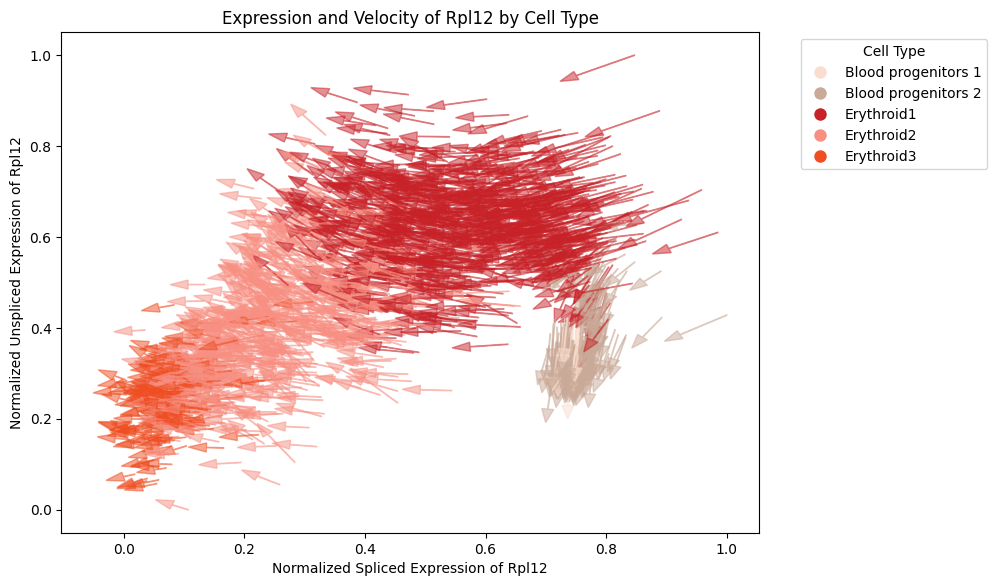

In [23]:
plot_phase_plane(adata, "Rpl12", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

IsADirectoryError: [Errno 21] Is a directory: '.'

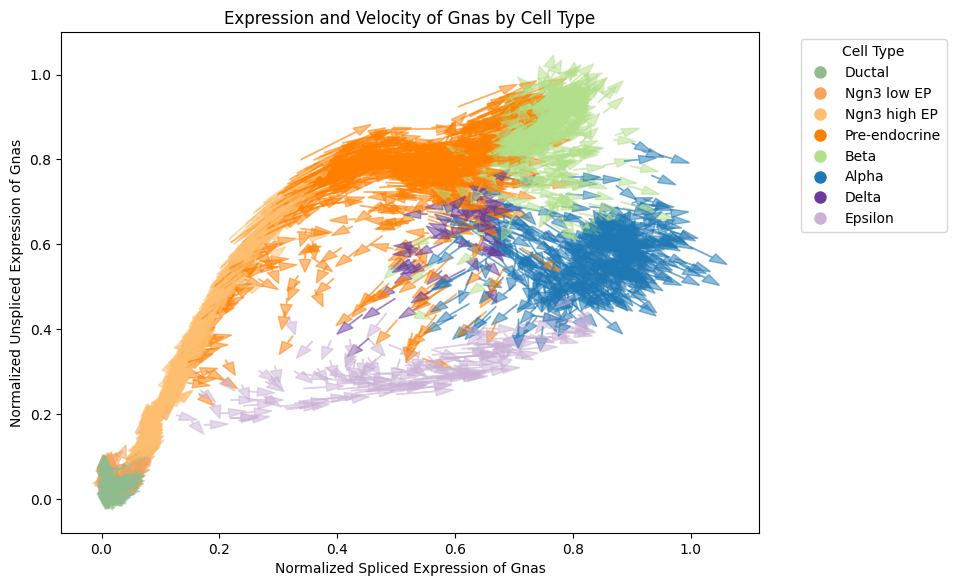

In [13]:
plot_phase_plane(adata, "Gnas", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [14]:
adata.obs["isomap_1"] = Isomap(n_components=1, n_neighbors=n_knn_search).fit_transform(adata.layers["Ms"])

/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:487: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


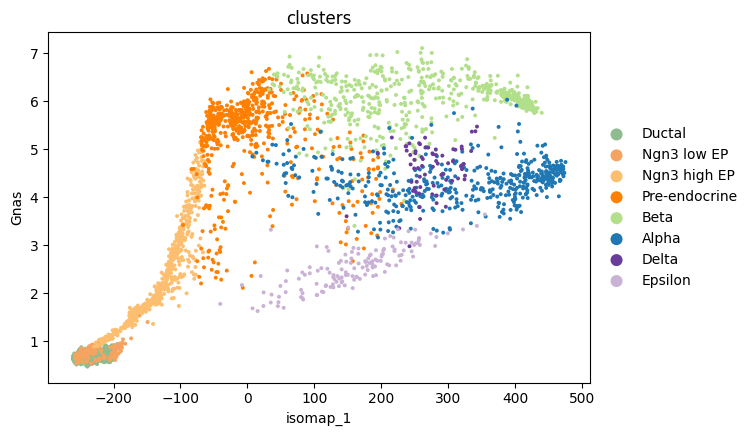

In [15]:
sc.pl.scatter(adata, x="isomap_1", y="Gnas", layers="Mu", color="clusters")

/mnt/data2/home/leonardo/miniconda3/envs/DeepTrajectory/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:487: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


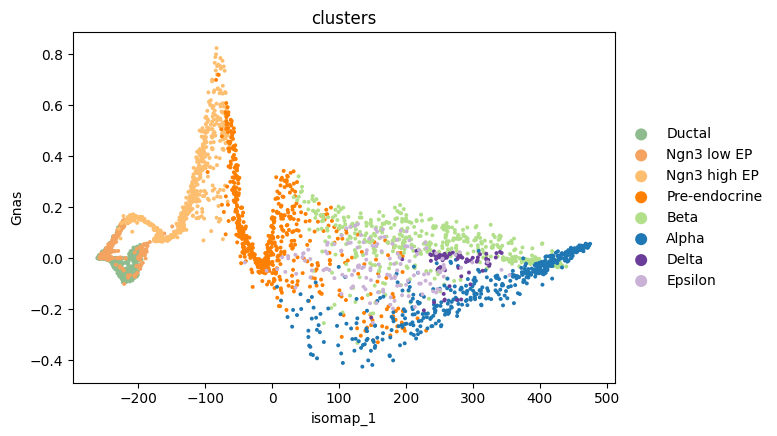

In [25]:
sc.pl.scatter(adata, x="isomap_1", y="Gnas", layers="velocity_u", color="clusters")

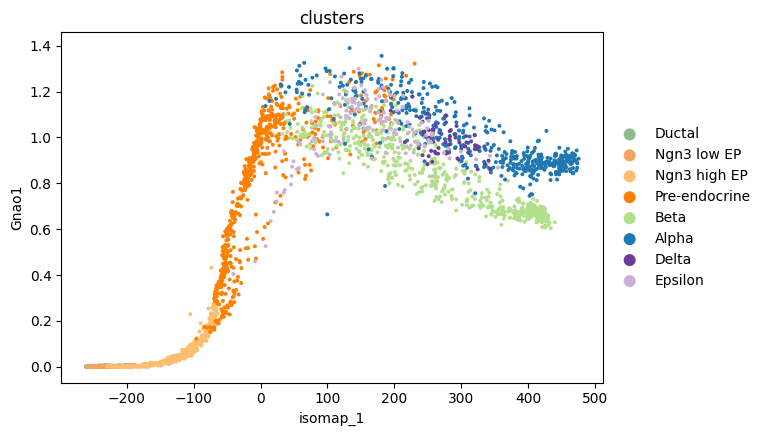

In [16]:
sc.pl.scatter(adata, x="isomap_1", y="Gnao1", layers="Ms", color="clusters")

In [ ]:
sc.pl.scatter(adata, x="isomap_1", y="Gnao1", layers="velocity_u", color="clusters")

In [ ]:
plot_phase_plane(adata, "Gnao1", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [ ]:
plot_phase_plane(adata, "Gnas", dataset_name, 11, u_scale=0.1, s_scale=0.1, cell_type_key=cell_type_key)

In [ ]:
#adata.write_h5ad("pancreas_goodresult.h5ad")